In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.express as px
import geopandas as gpd
from geodatasets import get_path

In [17]:
# Read CSVs
amphibians_csv = pd.read_csv("ERL_Pulse/Amphibians/European Red List of Amphibians 2025 - all species assessments.csv")
reptiles_csv = pd.read_csv("ERL_Pulse/Reptiles/European Red List of Reptiles 2025 - all species assessments.csv")
bees_csv = pd.read_csv("ERL_Pulse/Bees/European Red List of Bees 2025 - all species assessments.csv")

# Add 'group'
amphibians_csv['group'] = 'amphibian'
reptiles_csv['group'] = 'reptile'
bees_csv['group'] = 'bee'

# Combine CSVs
all_species_csv = pd.concat([amphibians_csv, reptiles_csv, bees_csv], ignore_index=True)
all_species_csv = all_species_csv.rename(columns={'Species name': 'species_name'})
print(all_species_csv.columns)
print(all_species_csv.shape)

Index(['Order', 'Family', 'species_name', 'Taxonomic authority', 'Common name',
       'taxon_id', 'assessment_id', 'European category',
       'EU 27 regional category', 'Endemic to Europe', 'Endemic to EU 27',
       'Link to assessment', 'group'],
      dtype='object')
(2463, 13)


In [18]:
# Standardize species names in the GeoDataFrames
species_name_col = {
    'amphibian': 'SCI_NAME',
    'reptile': 'sci_name',
    'bee': 'sci_name'
}

# Paths for GEM layers
gpkg_paths = {
    "amphibian": "ERL_Pulse/Amphibians/Amphibian_maps_all_geopackage.gpkg",
    "reptile": "ERL_Pulse/Reptiles/Reptile_maps_all_geopackage.gdb.gpkg",
    "bee": "ERL_Pulse/Bees/Bee_maps_all.gpkg"
}

# GEM layer names
gem_layers = {
    "amphibian": "Amphibian_maps_GEM",
    "reptile": "Reptile_maps_GEM",
    "bee": "Bee_maps_GEM"
}

# Read GEM layers, convert CRS to common CRS (WGS84 EPSG:4326), add group
gdfs = []
for group, path in gpkg_paths.items():
    gdf = gpd.read_file(path, layer=gem_layers[group])
    gdf = gdf.to_crs(epsg=4326)  # convert to WGS 84
    gdf['group'] = group
    # Add standardized species_name column
    gdf['species_name'] = gdf[species_name_col[group]]
    gdfs.append(gdf)

# Concatenate all GeoDataFrames
all_species_gdf = pd.concat(gdfs, ignore_index=True)
print(all_species_gdf.columns)
print(all_species_gdf.shape)

Index(['SCI_NAME', 'presence', 'origin', 'seasonal', 'compiler', 'citation',
       'source', 'dist_comm', 'island', 'subspecies', 'subpop', 'legend',
       'tax_comm', 'yrcompiled', 'data_sens', 'sens_comm', 'generalisd',
       'id_no', 'Shape_Leng', 'ASSESSMENT', 'Sci_name_1', 'geometry', 'group',
       'species_name', 'sci_name', 'PRESENCE', 'ORIGIN', 'SEASONAL',
       'assessment'],
      dtype='object')
(290, 29)


In [19]:
merged_gdf = all_species_gdf.merge(
    all_species_csv,
    on=['species_name', 'group'],
    how='left'
)

In [20]:
# Columns to always keep
base_cols = ['species_name', 'group', 'geometry', 'Order', 'Family', 
             'Common name', 'European category', 'EU 27 regional category', 
             'Endemic to Europe', 'Endemic to EU 27']

# Columns that may have duplicates
duplicate_cols = ['assessment', 'presence', 'origin', 'seasonal']

# Start cleaned GeoDataFrame
cleaned_gdf = merged_gdf[base_cols].copy()

# For each potentially duplicated column, combine duplicates by taking first non-null
for col in duplicate_cols:
    cols_to_merge = [c for c in merged_gdf.columns if c.lower() == col.lower()]
    cleaned_gdf[col] = merged_gdf[cols_to_merge].bfill(axis=1).iloc[:, 0]

In [21]:
print(cleaned_gdf.columns)
print(cleaned_gdf.shape)
cleaned_gdf[cleaned_gdf.isnull().any(axis=1)]

Index(['species_name', 'group', 'geometry', 'Order', 'Family', 'Common name',
       'European category', 'EU 27 regional category', 'Endemic to Europe',
       'Endemic to EU 27', 'assessment', 'presence', 'origin', 'seasonal'],
      dtype='object')
(290, 14)


,species_name,group,geometry,Order,Family,Common name,European category,EU 27 regional category,Endemic to Europe,Endemic to EU 27,assessment,presence,origin,seasonal
6,Bufotes balearicus,amphibian,"MULTIPOLYGON (((12.47481 44.88934, 12.48421 44...",Anura,Bufonidae,NaN,LC,LC,Yes,Yes,228180449.0,1.0,1.0,1.0
7,Bufotes balearicus,amphibian,"MULTIPOLYGON (((3.17381 39.95884, 3.16871 39.9...",Anura,Bufonidae,NaN,LC,LC,Yes,Yes,228180449.0,1.0,5.0,1.0
63,Iberolacerta cyreni,reptile,"MULTIPOLYGON (((-5.10946 40.24693, -4.8839 40....",Squamata,Lacertidae,NaN,LC,LC,Yes,Yes,137851751.0,1.0,1.0,1.0
70,Mediodactylus oertzeni,reptile,"MULTIPOLYGON (((28.23996 36.4353, 28.23963 36....",Squamata,Gekkonidae,NaN,LC,LC,Yes,Yes,204784677.0,1.0,1.0,1.0
82,Podarcis levendis,reptile,"MULTIPOLYGON (((23.2522 35.97602, 23.25221 35....",Squamata,Lacertidae,NaN,VU,VU,Yes,Yes,207654693.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,Simpanurgus phyllopodus,bee,"MULTIPOLYGON (((-3.87875 40.79182, -3.8683 40....",Hymenoptera,Andrenidae,NaN,CR,CR,Yes,Yes,222201063.0,4.0,1.0,1.0
286,Sphecodes aetnensis,bee,"MULTIPOLYGON (((15.58918 38.24238, 15.60808 38...",Hymenoptera,Halictidae,NaN,DD,DD,Yes,Yes,229923962.0,1.0,1.0,1.0
287,Sphecodes creticus,bee,"MULTIPOLYGON (((23.90707 35.23626, 23.91009 35...",Hymenoptera,Halictidae,NaN,LC,LC,Yes,Yes,222216586.0,1.0,1.0,1.0
288,Stelis ortizi,bee,"MULTIPOLYGON (((-5.41732 40.87752, -5.40591 40...",Hymenoptera,Megachilidae,NaN,LC,LC,Yes,Yes,222214120.0,1.0,1.0,1.0


C:\Users\jaden\AppData\Local\Temp\ipykernel_26536\4018600724.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cleaned_gdf, x='group', palette='Set2')


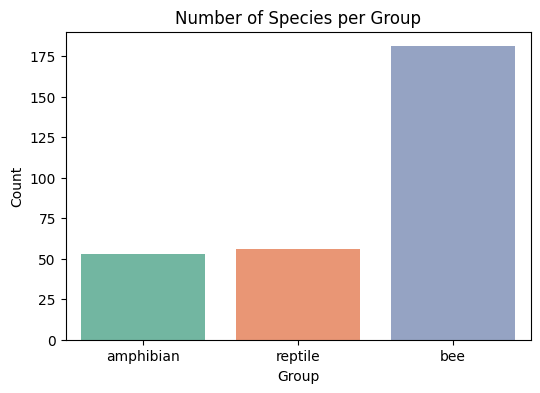

In [22]:
plt.figure(figsize=(6,4))
sns.countplot(data=cleaned_gdf, x='group', palette='Set2')
plt.title("Number of Species per Group")
plt.ylabel("Count")
plt.xlabel("Group")
plt.show()


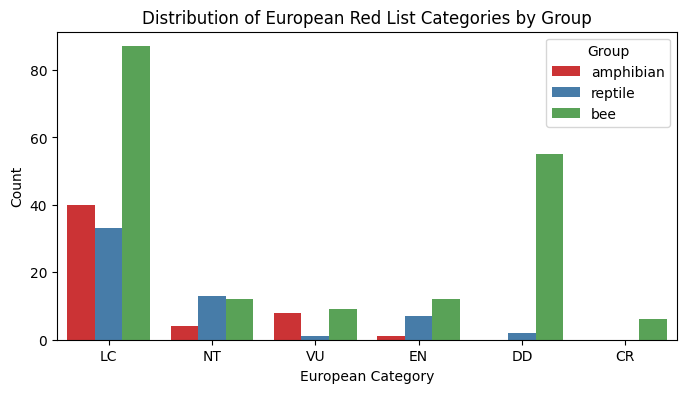

In [23]:
plt.figure(figsize=(8,4))
sns.countplot(data=cleaned_gdf, x='European category', hue='group', palette='Set1')
plt.title("Distribution of European Red List Categories by Group")
plt.ylabel("Count")
plt.xlabel("European Category")
plt.legend(title='Group')
plt.show()
# LC = Least Concern
# NT = Near Threatened
# VU = Vulnerable
# EN = Endangered
# CR = Critically Endangered
# DD = Data Deficient

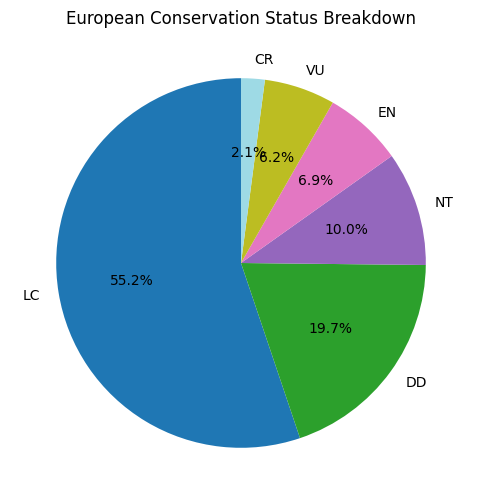

In [24]:
plt.figure(figsize=(6,6))
cleaned_gdf['European category'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                                      startangle=90, colormap='tab20')
plt.ylabel("")
plt.title("European Conservation Status Breakdown")
plt.show()


In [25]:
# Create a geometry_id
cleaned_gdf["geometry_id"] = cleaned_gdf["geometry"].factorize()[0]

# Build region table (drop duplicate geometries)
regions = cleaned_gdf.drop_duplicates("geometry_id")[["geometry", "geometry_id"]]

# Count species per region
species_per_region = cleaned_gdf.groupby("geometry_id").size().reset_index(name="species_count")

# Merge counts back into the region table
regions = regions.merge(species_per_region, on="geometry_id", how="left")


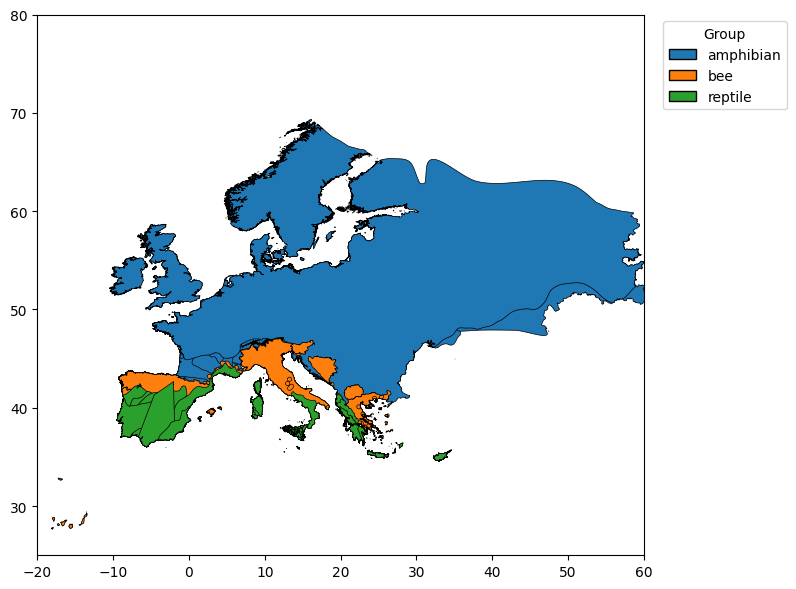

In [26]:
fig, ax = plt.subplots(figsize=(8,6))

# Choose a color palette
colors = plt.cm.tab10.colors   # 10 distinctive colors

# Dictionary: group → color
group_colors = {}

for i, (group_name, subset) in enumerate(cleaned_gdf.groupby("group")):
    color = colors[i % len(colors)]
    group_colors[group_name] = color
    subset.plot(ax=ax, color=color, edgecolor="black", linewidth=0.5)

# Create custom legend handles
legend_handles = [
    Patch(facecolor=group_colors[g], edgecolor="black", label=g)
    for g in group_colors
]

# Add legend
ax.legend(
    handles=legend_handles,
    title="Group",
    loc="upper left",
    bbox_to_anchor=(1.02, 1)
)

# Keep your European zoom
ax.set_xlim(-20, 60)
ax.set_ylim(25, 80)

plt.tight_layout()
plt.show()